# Прогнозирование оттока клиентов в сети отелей

### Описание проекта

Заказчик этого исследования — сеть отелей. 

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.
Бизнес-метрика и другие данные

### Бизнес-метрика и другие данные

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 


В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 
Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.


В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.


На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

### Описание данных

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:


- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика: 
    - Contract — договор с юридическим лицом;
    - Group — групповой заезд;
    - Transient — не связано с договором или групповым заездом;
    - Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа: 
    - SC — нет дополнительных опций;
    - BB — включён завтрак;
    - HB — включён завтрак и обед;
    - FB — включён завтрак, обед и ужин.
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
- total_of_special_requests — количество специальных отметок.

Добавляем библиотеки

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

Загружаем данные

In [ ]:
df = pd.read_csv('...')
test_df = pd.read_csv('...')

Изучаем данные

In [111]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [112]:
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


### Предобработка и исследовательский анализ данных

In [113]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,65229.0,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0


In [114]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,32412.0,60131.505183,29953.586177,6086.0,45291.75,53394.5,89800.25,97903.0
is_canceled,32412.0,0.388467,0.487409,0.0,0.00,0.0,1.00,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.00,76.0,155.00,373.0
arrival_date_year,32412.0,2017.000000,0.000000,2017.0,2017.00,2017.0,2017.00,2017.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.00,18.0,25.00,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.00,15.5,23.00,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.00,1.0,2.00,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.00,2.0,3.00,6.0
adults,32412.0,1.858602,0.489341,0.0,2.00,2.0,2.00,4.0
children,32412.0,0.083765,0.343470,0.0,0.00,0.0,0.00,3.0


In [115]:
print('Дубликаты обучающих данных:', df.duplicated().sum())
print('Дубликаты тестовых данных:', test_df.duplicated().sum())

Дубликаты обучающих данных: 0
Дубликаты тестовых данных: 0


In [116]:
print('Количество уникальных обучающих данных:', df.nunique())
print('Количество уникальных тестовых данных:', test_df.nunique())

Количество уникальных обучающих данных: id                                65229
is_canceled                           2
lead_time                           369
arrival_date_year                     2
arrival_date_month                   12
arrival_date_week_number             53
arrival_date_day_of_month            31
stays_in_weekend_nights               5
stays_in_week_nights                  7
adults                                5
children                              4
babies                                5
meal                                  5
country                             155
distribution_channel                  4
is_repeated_guest                     2
previous_cancellations               15
previous_bookings_not_canceled       58
reserved_room_type                    7
booking_changes                      16
days_in_waiting_list                 97
customer_type                         4
required_car_parking_spaces           4
total_of_special_requests             6


Изучаем распределение данных

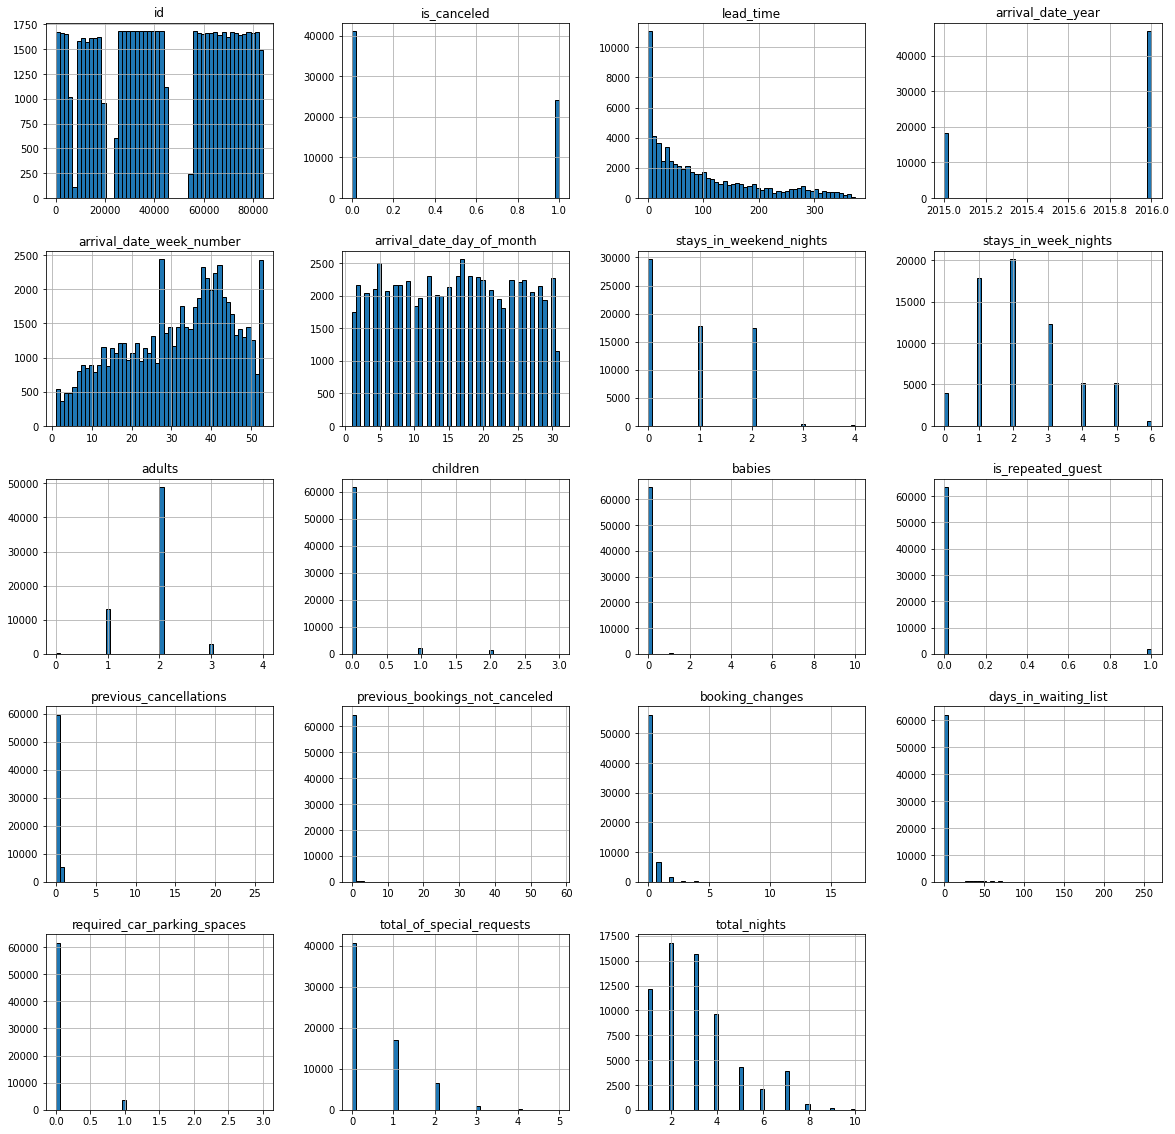

In [117]:
df.hist(bins=50, figsize=(20, 20), edgecolor='black');

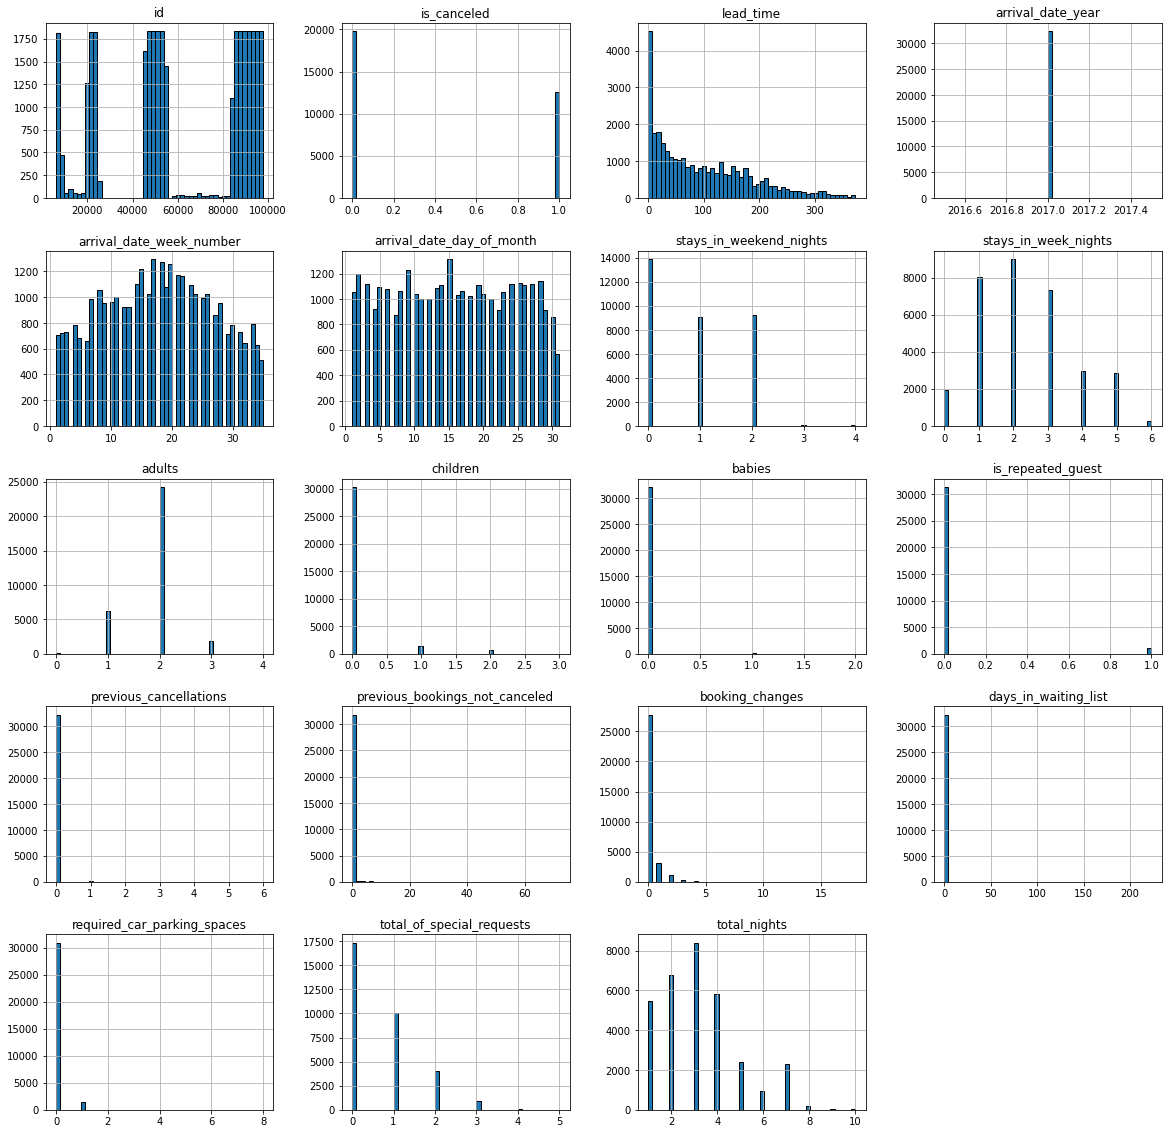

In [118]:
test_df.hist(bins=50, figsize=(20, 20), edgecolor='black');

Выводы на основе графиков:
В основном, рассматриваемые данные распределены нормально, но есть и различия между обучающей и тестовой выборками.
Например, в обучающей выборке идет скос в сторону клиентов, которые бронируют номера на 40й неделе, а в тестовой выборке больше клиентов, которые бронируют на 20й. Также, видно, что тестовая выборка имеет данные не за весь год.
В количестве ночей присутствет небольшие различия между обучающей и тестовой выборками. В обучающей выборке больше клиентов, которые бронируют номера на 1-2 ночи, а в тестовой выборке больше клиентов, которые бронируют на 3-4 ночи.
Различия не большие, но они есть.

In [119]:
df = df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

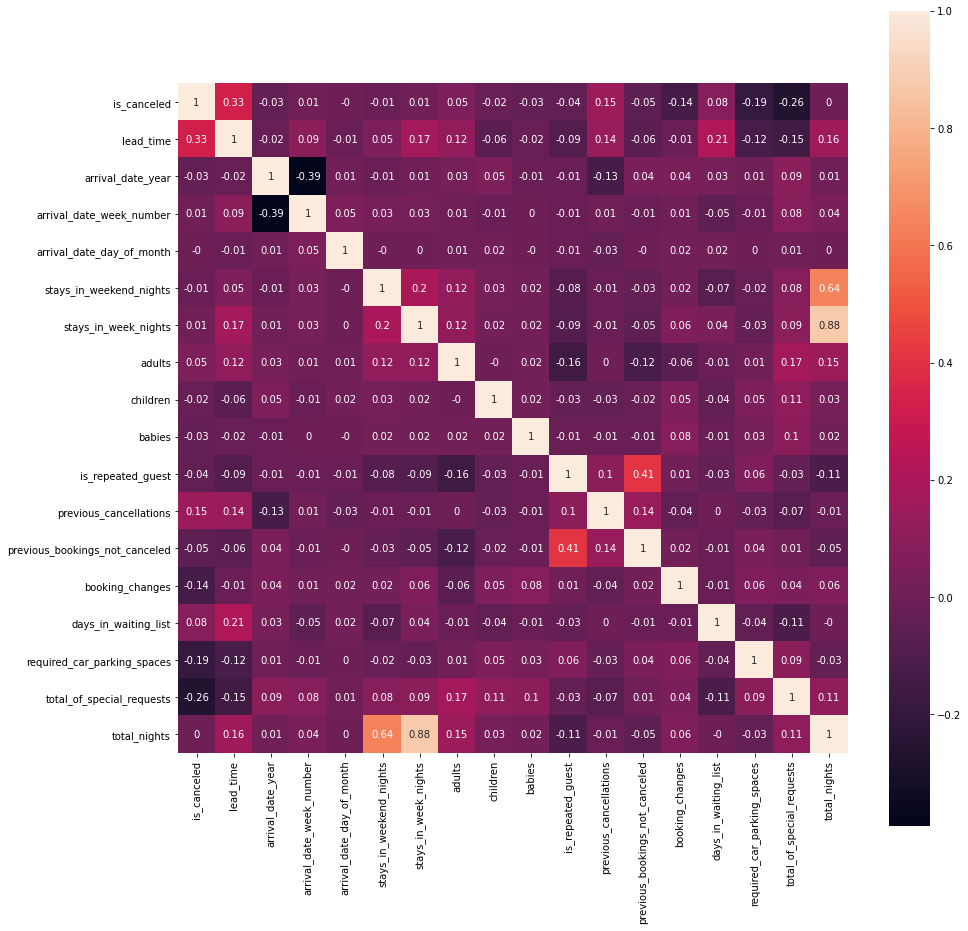

In [120]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr().round(2), annot=True, square=True);

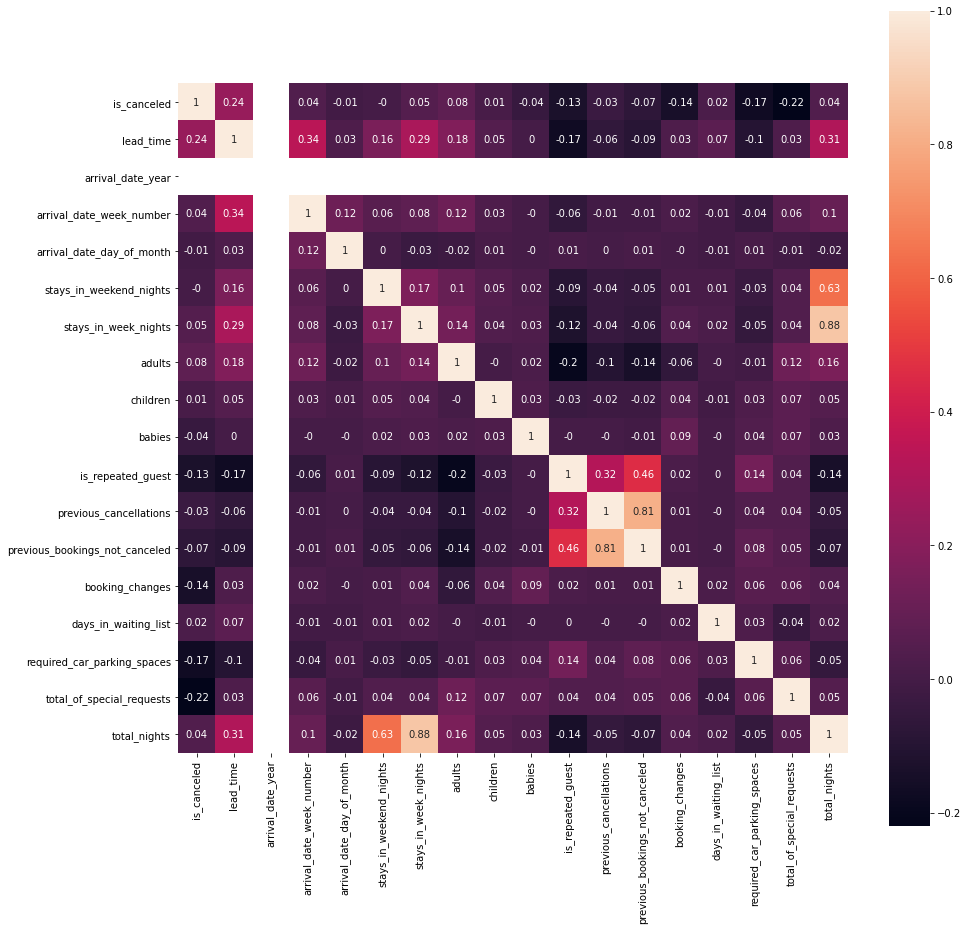

In [121]:
plt.figure(figsize=(15, 15))
sns.heatmap(test_df.corr().round(2), annot=True, square=True);

- Наблюдается небольшая корреляция между "lead_time" (количество дней между датой бронирования и датой прибытия) и "is_canceled" (индикатор отмены бронирования). Значение коэффициента корреляции для этих переменных - 0.24 - 0.33.
- Есть некоторая связь между "total_of_special_requests" (общее количество специальных запросов) и "is_canceled". Корреляции находится в диапазоне от -0.26 до -0.22.


Общее напровление корреляций схоже, но обучающие данные имеют большую выраженность.
Некоторые корреляции сильно различаются между обучающей и тестовой выборками, например: total_of_special_request - lead_time, is_repeated_guest - previous_cancelation и previous_cancelation - previous_booking_not_canceled.


Однако стоит отметить, что хотя корреляции присутствуют, они все довольно слабые (кроме трех, значения меньше 0,5), поэтому выводы, основанные на этих данных, следует делать осторожно.

### Формулировка ML-задачи на основе бизнес-задачи

Вычесляем бизнес-метрику

In [122]:
revenue_df = test_df

In [123]:
print(revenue_df['arrival_date_month'].unique())

['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']


In [124]:
# Функция для определения стоимости номера
def revenue_type(room_type):
    if 'A' in room_type:
        return 1000
    elif 'B' in room_type:
        return 800
    elif 'C' in room_type:
        return 600
    elif 'D' in room_type:
        return 550
    elif 'E' in room_type:
        return 500
    elif 'F' in room_type:
        return 450
    elif 'G' in room_type:
        return 350

In [125]:
# Функция для определения коэфициента сезонности
def season_rate(month):
    if 'June' in month or 'July' in month or 'August' in month:
        return 1.4
    elif 'December' in month or 'January' in month or 'February' in month:
        return 1
    else:
        return 1.2

In [126]:
# Функция для определения стоимости уборки
def cleaning_coasts(room_type):
    if 'A' in room_type:
        return 400
    elif 'B' in room_type:
        return 350
    elif 'C' in room_type:
        return 350
    elif 'D' in room_type:
        return 150
    elif 'E' in room_type:
        return 150
    elif 'F' in room_type:
        return 150
    elif 'G' in room_type:
        return 150

In [127]:
DEPOSIT = 0.8
BUDGET = 400000

Применяем функции к данным

In [128]:
revenue_df['type_revenue'] = revenue_df['reserved_room_type'].apply(revenue_type)
revenue_df['month_rate'] = revenue_df['arrival_date_month'].apply(season_rate)
revenue_df['cleaning_price'] = revenue_df['reserved_room_type'].apply(cleaning_coasts) 
revenue_df['cleaning_coasts'] = revenue_df['cleaning_price'] * round(revenue_df['total_nights'] / 2)

Считаем доход/расход на основе бизнес-метрики

Получаем прибыль за 2017 год

In [129]:
def calculate_profit(row):
    if row['is_canceled'] == 1:
        profit = (row['type_revenue'] * row['month_rate'] + row['cleaning_price']) * -1
    else:
        profit = row['type_revenue'] * row['month_rate'] * row['total_nights'] - row['cleaning_coasts']
    return profit

# использование функции
revenue_df['profit'] = revenue_df.apply(calculate_profit, axis=1)

# итоговая выручка
revenue_df['profit'].sum()

37186620.0

### Разработка модели ML

Изменяем настройки pandas для отображения всех столбцов

In [130]:
pd.set_option('display.max_columns', None)
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


Применяем OHE к категориальным признакам

In [131]:
ohe_month = df['arrival_date_month']
ohe_month = pd.get_dummies(ohe_month, drop_first=True)
ohe_meal = df['meal']
ohe_meal = pd.get_dummies(ohe_meal, drop_first=True)
ohe_country = df['country']
ohe_country = pd.get_dummies(ohe_country, drop_first=True)
ohe_distribution_channel = df['distribution_channel']
ohe_distribution_channel = pd.get_dummies(ohe_distribution_channel, drop_first=True)
ohe_reserved_room_type = df['reserved_room_type']
ohe_reserved_room_type = pd.get_dummies(ohe_reserved_room_type, drop_first=True)
ohe_customer_type = df['customer_type']
ohe_customer_type = pd.get_dummies(ohe_customer_type, drop_first=True)
print(ohe_month)
print(ohe_meal)
print(ohe_country)
print(ohe_distribution_channel)
print(ohe_reserved_room_type)
print(ohe_customer_type)

       August  December  February  January  July  June  March  May  November  \
0           0         0         0        0     1     0      0    0         0   
1           0         0         0        0     1     0      0    0         0   
2           0         0         0        0     1     0      0    0         0   
3           0         0         0        0     1     0      0    0         0   
4           0         0         0        0     1     0      0    0         0   
...       ...       ...       ...      ...   ...   ...    ...  ...       ...   
65224       0         1         0        0     0     0      0    0         0   
65225       0         1         0        0     0     0      0    0         0   
65226       0         1         0        0     0     0      0    0         0   
65227       0         1         0        0     0     0      0    0         0   
65228       0         1         0        0     0     0      0    0         0   

       October  September  
0          

Добавляем новые столбцы в таблицу

In [132]:
df = df.join(ohe_month)
df = df.join(ohe_meal)
df = df.join(ohe_country)
df = df.join(ohe_distribution_channel)
df = df.join(ohe_reserved_room_type)
df = df.join(ohe_customer_type)

In [133]:

df = df.drop(['arrival_date_month', 'meal', 'country', 'distribution_channel', 
              'reserved_room_type', 'customer_type'], axis=1)

In [134]:
columns = ['ASM', 'ATF', 'BHS', 'CAF', 'FJI', 'FRO', 'GHA', 'GTM', 'KIR', 'LAO', 'MDG', 'MRT', 'MYT', 'NCL', 'NPL', 'SDN', 'SLE', 'TGO', 'UMI']
for v in columns:
    df[v] = 0

In [135]:
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,August,December,February,January,July,June,March,May,November,October,September,FB,HB,SC,SC,AGO,ALB,AND,ARE,ARG,ARM,ATA,AUS,AUT,AZE,BDI,BEL,BEN,BFA,BGD,BGR,BHR,BIH,BLR,BOL,BRA,BRB,BWA,CHE,CHL,CHN,CIV,CMR,CN,COL,CPV,CRI,CUB,CYM,CYP,CZE,DEU,DMA,DNK,DOM,DZA,ECU,EGY,ESP,EST,ETH,FIN,FRA,GAB,GBR,GEO,GGY,GIB,GLP,GNB,GRC,GUY,HKG,HND,HRV,HUN,IDN,IMN,IND,IRL,IRN,IRQ,ISL,ISR,ITA,JAM,JEY,JOR,JPN,KAZ,KEN,KHM,KNA,KOR,KWT,LBN,LBY,LCA,LIE,LKA,LTU,LUX,LVA,MAC,MAR,MCO,MDV,MEX,MKD,MLI,MLT,MMR,MNE,MOZ,MUS,MWI,MYS,NAM,NGA,NIC,NLD,NOR,NZL,OMN,PAK,PAN,PER,PHL,PLW,POL,PRI,PRT,PRY,PYF,QAT,ROU,RUS,RWA,SAU,SEN,SGP,SLV,SMR,SRB,STP,SUR,SVK,SVN,SWE,SYC,SYR,THA,TJK,TMP,TUN,TUR,TWN,TZA,UGA,UKR,URY,USA,UZB,VEN,VGB,VNM,ZAF,ZMB,ZWE,Direct,GDS,TA/TO,B,C,D,E,F,G,Group,Transient,Transient-Party,ASM,ATF,BHS,CAF,FJI,FRO,GHA,GTM,KIR,LAO,MDG,MRT,MYT,NCL,NPL,SDN,SLE,TGO,UMI
0,0,7.0,2015,27,1,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,14.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,9.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,85.0,2015,27,1,0,3,2.0,0.0,0.0,0,0,0,0,0,0,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Готовим данные для обучения

In [136]:
features = df.drop(['is_canceled'], axis=1)
target = df['is_canceled']

In [137]:
scaler = StandardScaler()
scaler.fit(features)
features = pd.DataFrame(scaler.transform(features), columns=features.columns)

print(features.shape) 

(65229, 217)


In [138]:
features.head(10)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,August,December,February,January,July,June,March,May,November,October,September,FB,HB,SC,SC,AGO,ALB,AND,ARE,ARG,ARM,ATA,AUS,AUT,AZE,BDI,BEL,BEN,BFA,BGD,BGR,BHR,BIH,BLR,BOL,BRA,BRB,BWA,CHE,CHL,CHN,CIV,CMR,CN,COL,CPV,CRI,CUB,CYM,CYP,CZE,DEU,DMA,DNK,DOM,DZA,ECU,EGY,ESP,EST,ETH,FIN,FRA,GAB,GBR,GEO,GGY,GIB,GLP,GNB,GRC,GUY,HKG,HND,HRV,HUN,IDN,IMN,IND,IRL,IRN,IRQ,ISL,ISR,ITA,JAM,JEY,JOR,JPN,KAZ,KEN,KHM,KNA,KOR,KWT,LBN,LBY,LCA,LIE,LKA,LTU,LUX,LVA,MAC,MAR,MCO,MDV,MEX,MKD,MLI,MLT,MMR,MNE,MOZ,MUS,MWI,MYS,NAM,NGA,NIC,NLD,NOR,NZL,OMN,PAK,PAN,PER,PHL,PLW,POL,PRI,PRT,PRY,PYF,QAT,ROU,RUS,RWA,SAU,SEN,SGP,SLV,SMR,SRB,STP,SUR,SVK,SVN,SWE,SYC,SYR,THA,TJK,TMP,TUN,TUR,TWN,TZA,UGA,UKR,URY,USA,UZB,VEN,VGB,VNM,ZAF,ZMB,ZWE,Direct,GDS,TA/TO,B,C,D,E,F,G,Group,Transient,Transient-Party,ASM,ATF,BHS,CAF,FJI,FRO,GHA,GTM,KIR,LAO,MDG,MRT,MYT,NCL,NPL,SDN,SLE,TGO,UMI
0,-0.929376,-1.599681,-0.322326,-1.697258,-0.966858,-0.903918,-1.741989,-0.224060,-0.073248,-0.167058,-0.133547,-0.081193,-0.327145,-0.182814,-0.244069,-0.681336,-1.179440,-0.337719,-0.303361,-0.232968,-0.172835,3.226091,-0.277343,-0.260595,-0.27792,-0.311249,-0.406626,-0.394436,-0.083440,-0.354769,-0.089208,-0.296591,-0.046378,-0.01036,-0.003915,-0.019969,-0.040535,-0.009591,-0.003915,-0.050815,-0.10535,-0.011747,-0.003915,-0.139492,-0.003915,-0.003915,-0.011747,-0.027137,-0.003915,-0.012383,-0.012987,-0.011747,-0.130241,-0.007831,-0.003915,-0.116537,-0.025383,-0.090163,-0.005537,-0.009591,-0.08682,-0.023499,-0.015166,-0.013565,-0.003915,-0.003915,-0.016614,-0.041473,-0.251726,-0.003915,-0.055597,-0.006782,-0.030845,-0.012383,-0.019185,-0.284994,-0.026275,-0.003915,-0.060896,-0.317519,-0.006782,3.430374,-0.012383,-0.006782,-0.012383,-0.005537,-0.009591,-0.035261,-0.003915,-0.015664,-0.003915,-0.028784,-0.04311,-0.017069,-0.003915,-0.036755,-0.150514,-0.028246,-0.013565,-0.017946,-0.076041,-0.192338,-0.005537,-0.008756,-0.013565,-0.04239,-0.012383,-0.005537,-0.005537,-0.003915,-0.032304,-0.012383,-0.016614,-0.01036,-0.003915,-0.005537,-0.006782,-0.025684,-0.045371,-0.021451,-0.005537,-0.043818,-0.005537,-0.008756,-0.025981,-0.011747,-0.003915,-0.013565,-0.003915,-0.006782,-0.022837,-0.008756,-0.005537,-0.017946,-0.003915,-0.016614,-0.003915,-0.13491,-0.063383,-0.025981,-0.012383,-0.009591,-0.007831,-0.015166,-0.012383,-0.003915,-0.090595,-0.011075,-0.890002,-0.003915,-0.003915,-0.009591,-0.061903,-0.067517,-0.003915,-0.017069,-0.006782,-0.019969,-0.003915,-0.003915,-0.035261,-0.003915,-0.006782,-0.025981,-0.026275,-0.091706,-0.003915,-0.003915,-0.027137,-0.011075,-0.006782,-0.02109,-0.050967,-0.019581,-0.006782,-0.003915,-0.026565,-0.012383,-0.125283,-0.003915,-0.017513,-0.003915,-0.008756,-0.023499,-0.003915,-0.003915,2.918615,-0.038988,-2.248051,-0.115587,-0.059225,-0.409999,-0.197466,-0.137653,-0.095702,-0.066478,0.658654,-0.586692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.856555,-1.599681,-0.322326,-1.697258,-0.966858,-0.165901,0.340296,-0.224060,-0.073248,-0.167058,-0.133547,-0.081193,-0.327145,-0.182814,-0.244069,0.647419,-0.604097,-0.337719,-0.303361,-0.232968,-0.172835,3.226091,-0.277343,-0.260595,-0.27792,-0.311249,-0.406626,-0.394436,-0.083440,-0.354769,-0.089208,-0.296591,-0.046378,-0.01036,-0.003915,-0.019969,-0.040535,-0.009591,-0.003915,-0.050815,-0.10535,-0.011747,-0.003915,-0.139492,-0.003915,-0.003915,-0.011747,-0.027137,-0.003915,-0.012383,-0.012987,-0.011747,-0.130241,-0.007831,-0.003915,-0.116537,-0.025383,-0.090163,-0.005537,-0.009591,-0.08682,-0.023499,-0.015166,-0.013565,-0.003915,-0.003915,-0.016614,-0.041473,-0.251726,-0.003915,-0.055597,-0.006782,-0.030845,-0.012383,-0.019185,-0.284994,-0.026275,-0.003915,-0.060896,-0

### Проверяем показетели логистической регрессии

Задача стоит в разработке системы прогнозирования оплаты или отмены бронирования в отеле. Наша основная цель - минимизировать убытки отеля от возможных отмен бронирования. Если мы можем предсказать отмену бронирования заблаговременно, это поможет нам сократить издержки и увеличить прибыль отеля.

- Однако, реализация такой системы может повлечь убытки в случае ложного предсказания: если система ошибочно предположит, что клиент не отменит бронирование, а в итоге отмена происходит (ложноотрицательное предсказание). В этом контексте, метрика "recall" будет очень полезна, так как она помогает нам определить, как много положительных случаев мы смогли правильно предсказать.

- Добавление F1-меры поможет нам учесть и точность предсказаний, обеспечив баланс между recall и precision, и показывая, насколько хорошо модель отличает нужный нам класс от других и правильно его предсказывает.

- Метрика AUC-ROC также будет полезна, поскольку она поможет нам оценить, насколько хорошо наша модель работает в сравнении с произвольным предсказанием (когда AUC-ROC равна 0,5).

Однако, в контексте нашего вопроса, recall может быть более важной метрикой, так как более важно идентифицировать и предотвратить отмены бронирований (истинно положительные случаи), чем неправильно предсказать отмену, которая не произойдет (ложно положительные случаи).

In [41]:
#Метрики для оценки

scoring = ['recall', 'f1', 'roc_auc']

In [32]:
%%time

logistic_regression = LogisticRegression(random_state=12345, solver='liblinear')

param_grid = {'max_iter': range(100, 501, 100), 'penalty': ['l2', 'l1']}

grid = GridSearchCV(logistic_regression, param_grid, scoring=scoring, refit='recall')

grid.fit(features, target)

metrics_columns = [f'mean_test_{x}' for x in scoring]
final_metrics = pd.DataFrame(grid.cv_results_)[metrics_columns].iloc[grid.best_index_]

print(grid.best_estimator_)
display(final_metrics)

LogisticRegression(random_state=12345, solver='liblinear')


mean_test_recall     0.474483
mean_test_f1         0.480477
mean_test_roc_auc    0.696946
Name: 0, dtype: float64

CPU times: user 2h 9min 26s, sys: 26.7 s, total: 2h 9min 53s
Wall time: 2h 10min


### Поиск наиболее эффективные гиперпараметры решающего дерева

In [33]:
%%time

tree_model = DecisionTreeClassifier(random_state=12345)

param_grid = {'max_depth': range(2, 21, 2), 'criterion': ['gini', 'entropy']}

grid = GridSearchCV(tree_model, param_grid, scoring=scoring, refit='recall')

grid.fit(features, target)

metrics_columns = [f'mean_test_{x}' for x in scoring]
final_metrics = pd.DataFrame(grid.cv_results_)[metrics_columns].iloc[grid.best_index_]

print(grid.best_estimator_)
display(final_metrics)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=12345)


mean_test_recall     0.535656
mean_test_f1         0.592991
mean_test_roc_auc    0.685433
Name: 11, dtype: float64

CPU times: user 38.9 s, sys: 3.8 s, total: 42.7 s
Wall time: 42.8 s


### Поиск наиболее эффективные гиперпараметры случайного леса

In [34]:
%%time

forest_model = RandomForestClassifier(random_state=12345)

param_grid = {'max_depth': range(2, 21, 2), 'n_estimators': range(50, 351, 50), 'criterion': ['gini', 'entropy']}

grid = GridSearchCV(forest_model, param_grid, scoring=scoring, refit='recall')
grid.fit(features, target)

metrics_columns = [f'mean_test_{x}' for x in scoring]
final_metrics = pd.DataFrame(grid.cv_results_)[metrics_columns].iloc[grid.best_index_]

print(grid.best_estimator_)
display(final_metrics)

RandomForestClassifier(max_depth=16, n_estimators=50, random_state=12345)


mean_test_recall     0.462671
mean_test_f1         0.487275
mean_test_roc_auc    0.680014
Name: 49, dtype: float64

CPU times: user 1h 20min 44s, sys: 28.3 s, total: 1h 21min 12s
Wall time: 1h 21min 14s


In [165]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
cross_val_score(model_lr, features, target, scoring='recall').mean()

0.5624021048304811

In [168]:
balanced_tree_model = DecisionTreeClassifier(random_state=12345, max_depth=9, class_weight='balanced')
cross_val_score(tree_model, features, target, scoring='recall').mean()

0.5487182674332548

In [169]:
balanced_forest_model = RandomForestClassifier(random_state=12345, n_estimators=40, 
                                      max_depth=10, class_weight='balanced')
cross_val_score(forest_model, features, target, scoring='recall').mean()

0.5742959851692386

## Тестирование модели

Готовим данные для тестирования

In [79]:
test_df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,type_revenue,month_rate,cleaning_price,cleaning_coasts,profit
0,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,1.0,400,0.0,-1400.0
1,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,1.0,400,800.0,-1400.0
2,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,1.0,400,800.0,-1400.0
3,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,1.0,400,800.0,-1400.0
4,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,1.0,400,1600.0,-1400.0


In [139]:
revenue_df = test_df

In [140]:
test_ohe_month = test_df['arrival_date_month']
test_ohe_month = pd.get_dummies(test_ohe_month, drop_first=True)
test_ohe_meal = test_df['meal']
test_ohe_meal = pd.get_dummies(test_ohe_meal, drop_first=True)
test_ohe_country = test_df['country']
test_ohe_country = pd.get_dummies(test_ohe_country, drop_first=True)
test_ohe_distribution_channel = test_df['distribution_channel']
test_ohe_distribution_channel = pd.get_dummies(test_ohe_distribution_channel, drop_first=True)
test_ohe_reserved_room_type = test_df['reserved_room_type']
test_ohe_reserved_room_type = pd.get_dummies(test_ohe_reserved_room_type, drop_first=True)
test_ohe_customer_type = test_df['customer_type']
test_ohe_customer_type = pd.get_dummies(test_ohe_customer_type, drop_first=True)


In [141]:
print(test_ohe_month)
print(test_ohe_meal)
print(test_ohe_country)
print(test_ohe_distribution_channel)
print(test_ohe_reserved_room_type)
print(test_ohe_customer_type)

       August  February  January  July  June  March  May
0           0         0        1     0     0      0    0
1           0         0        1     0     0      0    0
2           0         0        1     0     0      0    0
3           0         0        1     0     0      0    0
4           0         0        1     0     0      0    0
...       ...       ...      ...   ...   ...    ...  ...
32407       1         0        0     0     0      0    0
32408       1         0        0     0     0      0    0
32409       1         0        0     0     0      0    0
32410       1         0        0     0     0      0    0
32411       1         0        0     0     0      0    0

[32412 rows x 7 columns]
       FB         HB         SC  SC       
0              0          0   0          0
1              0          0   0          0
2              0          0   0          0
3              0          0   0          0
4              0          0   0          0
...          ...        ...  .. 

In [142]:

test_df = test_df.join(test_ohe_month)
test_df = test_df.join(test_ohe_meal)
test_df = test_df.join(test_ohe_country)
test_df = test_df.join(test_ohe_distribution_channel)
test_df = test_df.join(test_ohe_reserved_room_type)
test_df = test_df.join(test_ohe_customer_type)


In [143]:

test_df = test_df.drop(['arrival_date_month', 'meal', 'country', 'distribution_channel', 
              'reserved_room_type', 'customer_type'], axis=1)

test_df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,type_revenue,month_rate,cleaning_price,cleaning_coasts,profit,August,February,January,July,June,March,May,FB,HB,SC,SC,AGO,ALB,AND,ARE,ARG,ASM,ATA,ATF,AUS,AUT,AZE,BEL,BEN,BGD,BGR,BHR,BHS,BIH,BLR,BRA,CAF,CHE,CHL,CHN,CIV,CMR,CN,COL,CPV,CRI,CUB,CYP,CZE,DEU,DNK,DOM,DZA,ECU,EGY,ESP,EST,ETH,FIN,FJI,FRA,FRO,GAB,GBR,GHA,GIB,GNB,GRC,GTM,HKG,HRV,HUN,IDN,IMN,IND,IRL,IRN,IRQ,ISL,ISR,ITA,JAM,JEY,JOR,JPN,KAZ,KEN,KIR,KOR,KWT,LAO,LBN,LBY,LIE,LKA,LTU,LUX,LVA,MAC,MAR,MCO,MDG,MDV,MEX,MLT,MNE,MOZ,MRT,MUS,MYS,MYT,NCL,NGA,NLD,NOR,NPL,NZL,PAK,PAN,PER,PHL,POL,PRI,PRT,PRY,QAT,ROU,RUS,SAU,SDN,SEN,SGP,SLE,SLV,SRB,STP,SUR,SVK,SVN,SWE,SYC,SYR,TGO,THA,TJK,TUN,TUR,TWN,TZA,UKR,UMI,URY,USA,UZB,VEN,VNM,ZAF,ZWE,Direct,GDS,TA/TO,B,C,D,E,F,G,Group,Transient,Transient-Party
0,1,74.0,2017,1,1,1,0,2.0,0.0,0.0,0,0,0,0,0,0,0,1,1000,1.0,400,0.0,-1400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,62.0,2017,1,1,2,2,2.0,0.0,0.0,0,0,0,0,0,0,1,4,1000,1.0,400,800.0,-1400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,62.0,2017,1,1,2,2,2.0,0.0,0.0,0,0,0,0,0,0,1,4,1000,1.0,400,800.0,-1400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1,71.0,2017,1,1,2,2,1.0,0.0,0.0,0,0,0,0,0,0,1,4,1000,1.0,400,800.0,-1400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,172.0,2017,1,1,2,5,2.0,0.0,0.0,0,0,0,0,0,0,0,7,1000,1.0,400,1600.0,-1400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [144]:
columns = ['December', 'November', 'October', 'September', 'ARM', 'BDI', 'BFA', 'BOL', 'BRB', 'BWA', 'CYM', 'DMA', 'GEO', 'GGY', 'GLP', 'GUY', 'HND', 'KHM', 'KNA', 'LCA', 'MKD', 'MLI', 'MMR', 'MWI', 'NAM', 'NIC', 'OMN', 'PLW', 'PYF', 'RWA', 'SMR', 'TMP', 'UGA', 'VGB', 'ZMB']
for v in columns:
    test_df[v] = 0

In [164]:
features_test = test_df.drop(['is_canceled', 'cleaning_coasts', 'cleaning_price', 'month_rate', 'profit', 'type_revenue'], axis=1)
target_test = test_df['is_canceled']

features_test = features_test[features.columns]

In [170]:
model = balanced_forest_model.fit(features, target)
final_result = pd.Series(model.predict(features_test))

score_recall = recall_score(target_test, final_result)
score_f1 = f1_score(target_test, final_result)
score_roc_auc = roc_auc_score(target_test, final_result)

print("Recall:", round(score_recall, 3))
print("F1-мера:", round(score_f1, 3))
print("AUC-ROC:", round(score_roc_auc, 3))

Recall: 0.436
F1-мера: 0.535
AUC-ROC: 0.656


In [171]:
predict = final_result.astype('int64')
revenue_df['predict'] = predict
revenue_df.head(2)


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,type_revenue,month_rate,cleaning_price,cleaning_coasts,profit,predict,profit_ml,profit_no_ml
0,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,1.0,400,0.0,-1400.0,1,0.0,-1400.0
1,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,1.0,400,800.0,-1400.0,0,-1400.0,-1400.0


In [172]:
revenue_df['predict'].value_counts()

0    24461
1     7951
Name: predict, dtype: int64

In [173]:
def profit(row, str_type):
    # Учет затрат и выручки с каждого клиента
    costs_for_client = 0
    user_payment = 0

    # Отдельные переменные для каждого из необходимых столбцов 
    index = row.name
    month = row['arrival_date_month']
    room_type = row['reserved_room_type']
    total_nights = row['total_nights']
    price = row['type_revenue']
    service = row['cleaning_price']

    # Учет сезонных коэффициентов в ценовой политике
    if 'June' in month or 'July' in month or 'August' in month:
        price *= 1.2
    elif 'March' in month or 'April' in month or 'May' in month or 'September' in month \
    or 'October' in month or 'November' in month:
        return 1.2
    
    if str_type == 'ml':
        # Если система предсказывает отмену брони
        if row['predict'] == 1:
            # Представим, что лишь половина согласиться внести депозит (остальные откажутся от брони вовсе)
            if np.random.randint(2) == 1:
                # Внесение депозита и затрат за первую ночь и обслуживание
                user_payment += (price + service) * DEPOSIT
                costs_for_client += price + service

                # Если бронь не отменена - начисление полной стоимости и обслуживания
                if row['is_canceled'] == 0:
                    user_payment += (price + service) * (1 - DEPOSIT) + (total_nights - 1) * price

                    for i in range(2, total_nights, 2):
                        costs_for_client += service
        # Если система предсказывает покупку, и она осуществляется
        elif row['predict'] == 0 and row['is_canceled'] == 0:
            # Начисление полной стоимости и обслуживания за все дни проживаиня
            user_payment += total_nights * price

            for i in range(0, total_nights, 2):
                costs_for_client += service
        # Если система предсказывает покупку, но осуществлена отмена брони - начисление издержек
        elif row['predict'] == 0  and row['is_canceled'] == 1:
            costs_for_client += price + service
        
    elif str_type == 'no_ml': # Расчет прибыли без внедрения системы прогнозирования
        # Если бронь осуществлена - начисление выручки и затрат
        if row['is_canceled'] == 0:
            user_payment += total_nights * price
            
            for i in range(0, total_nights, 2):
                costs_for_client += service
        # Если бронь отменена - начисление затрат
        elif row['is_canceled'] == 1:
            costs_for_client += price + service

    revenue_from_client = user_payment - costs_for_client
    
    return revenue_from_client


In [174]:
revenue_df['profit_ml'] = revenue_df.apply(lambda x: profit(x, 'ml'), axis=1)
revenue_df['profit_no_ml'] = revenue_df.apply(lambda x: profit(x, 'no_ml'), axis=1)

print("Прибыль - ")
print("\tПри использовании системы прогнозирования:", "{:,}".format(revenue_df['profit_ml'].sum() - BUDGET))
print("\tБез использования системы прогнозирования:", "{:,}".format(revenue_df['profit_no_ml'].sum()))

Прибыль - 
	При использовании системы прогнозирования: 19,060,130.4
	Без использования системы прогнозирования: 18,055,880.4


Начало внедрения модели 1 января 2017 года

In [175]:
display(revenue_df.loc[0])

is_canceled                                      1
lead_time                                     74.0
arrival_date_year                             2017
arrival_date_month                         January
arrival_date_week_number                         1
arrival_date_day_of_month                        1
stays_in_weekend_nights                          1
stays_in_week_nights                             0
adults                                         2.0
children                                       0.0
babies                                         0.0
meal                                     BB       
country                                        PRT
distribution_channel                         TA/TO
is_repeated_guest                                0
previous_cancellations                           0
previous_bookings_not_canceled                   0
reserved_room_type                A               
booking_changes                                  0
days_in_waiting_list           

In [176]:
display(df['arrival_date_year'].value_counts().to_frame())
display(test_df['arrival_date_year'].value_counts().to_frame())

,arrival_date_year
2016,46901
2015,18328


,arrival_date_year
2017,32412


In [177]:
# Получаем списки прибыли до и после внедрения депозитов
profit_after_ml = list(revenue_df['profit_ml'])
profit = list(revenue_df['profit_no_ml'])

# Задаем начальные значения для вычисления окупаемости модели
profit_before = 0
profit_ml_opti = 0
payback = 0
index = 0

# Вычисляем индекс объекта, на котором модель окупилась при положительном сценарии
while payback <= BUDGET:
    profit_before += profit[index]
    profit_ml_opti += profit_after_ml[index]
    payback = profit_ml_opti - profit_before
    index += 1
    
# Выводим результаты
print('Первое значение, превышающее бюджет:', payback)
print('Индекс объекта, на котором модель окупилась при положительном сценарии:', index)

Первое значение, превышающее бюджет: 400651.99999999994
Индекс объекта, на котором модель окупилась при положительном сценарии: 1685


Дата окупаемости модели 27 июня 2017 года

In [179]:
display(revenue_df.loc[1685])

is_canceled                                      1
lead_time                                    310.0
arrival_date_year                             2017
arrival_date_month                            June
arrival_date_week_number                        26
arrival_date_day_of_month                       27
stays_in_weekend_nights                          2
stays_in_week_nights                             5
adults                                         2.0
children                                       2.0
babies                                         0.0
meal                                     BB       
country                                        GBR
distribution_channel                         TA/TO
is_repeated_guest                                0
previous_cancellations                           0
previous_bookings_not_canceled                   0
reserved_room_type                G               
booking_changes                                  0
days_in_waiting_list           

### Вывод
При внедрении модели в 2017 году, отель получил бы прибыль в примерно 1 миллионов рублей. Модель можно сильно улучшить, что увеличит прибыль кратно.

Внедрение системы прогнозирования отмены бронирования номера позволяет отелю не только сохранить имеющуюся прибыль, но и увеличить ее. Это достигается через требование депозита в размере 80% от стоимости номера за одни сутки, а также возможность компенсировать затраты на разовую уборку.

Из этого следует, что введение такой системы при бронировании номеров в отеле клиентами является обоснованным, поскольку оно помогает снизить риски потерь от простоя номеров или непродажи закупленных продуктов.

### Опишем портрет «ненадёжного» клиента

In [180]:
revenue_df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,type_revenue,month_rate,cleaning_price,cleaning_coasts,profit,predict,profit_ml,profit_no_ml
0,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,1.0,400,0.0,-1400.0,1,0.0,-1400.0
1,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,1.0,400,800.0,-1400.0,0,-1400.0,-1400.0
2,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,1.0,400,800.0,-1400.0,0,-1400.0,-1400.0
3,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,1.0,400,800.0,-1400.0,1,0.0,-1400.0
4,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,1.0,400,1600.0,-1400.0,0,-1400.0,-1400.0


In [181]:
def create_ratio_plot(col_name, str_name, bar_color):
    # Создание DataFrame с количеством отмененных / не отмененных бронирований по данному признаку
    ratio_df = revenue_df.pivot_table(index=[col_name, 'is_canceled'], values='country', aggfunc='count').reset_index()

    # Вычисление процента отмены для каждого уникального значения данного признака
    percentages = [
        round(ratio_df.loc[i+1, 'country'] / ratio_df.loc[i, 'country'] * 100, 2) 
        if (i + 1) < len(ratio_df) else 0 
        for i in range(0, len(ratio_df), 2)
    ]

    # Создание DataFrame с процентами
    percentage_df = pd.DataFrame({
        col_name: sorted(df[col_name].unique()),
        'percentage': percentages
    })

    # Построение графика процентов отмены по данному признаку
    ax = percentage_df.plot(
        x=col_name,
        y='percentage',
        kind='bar',
        color=bar_color,
        grid=True,
        legend=False,
        figsize=(6, 4),
    )
    
    ax.set_xlabel(str_name)
    ax.set_xticklabels(percentage_df[col_name], rotation=0)
    ax.set_ylabel('Процент отмены бронирования')
    ax.set_title(f'Соотношение отмененных/неотмененных бронирований\nпо "{str_name}", в %')

    plt.show()

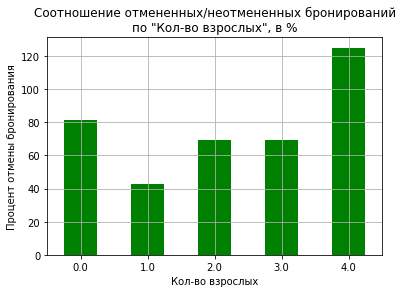

In [182]:
create_ratio_plot('adults', 'Кол-во взрослых', 'green')

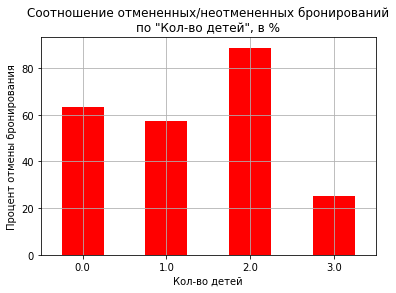

In [183]:
create_ratio_plot('children', 'Кол-во детей', 'red')

In [184]:
revenue_df[revenue_df['is_canceled'] == 1]['country'].value_counts().head()

PRT    5893
GBR    1069
FRA     857
ESP     614
DEU     573
Name: country, dtype: int64

In [185]:
def analyze_bookings(df, is_canceled):
    df_temp = df[df['is_canceled'] == is_canceled].pivot_table(
        index='lead_time', values='adults', aggfunc='count'
    ).reset_index()
    df_temp.columns = ['lead_time', 'clients_number']
    print('С отменой бронирования:' if is_canceled else 'Без отмены бронирования:')
    display(df_temp.sort_values(by='clients_number', ascending=False).head(10))
    print("Медианное время между прибытием и бронированием:", df_temp['lead_time'].median(), "\n\n")

def analyze_requests(df, is_canceled):
    df_temp = df[df['is_canceled'] == is_canceled].pivot_table(
        index='total_of_special_requests', values='adults', aggfunc='count'
    ).reset_index()
    df_temp.columns = ['total_of_special_requests', 'clients_number']
    display("Количество пометок по клиентам" + 
            (", отменивших бронь:" if is_canceled else ", не отменивших бронь:"),
            df_temp.sort_values(by='clients_number', ascending=False))

analyze_bookings(revenue_df, 1)
analyze_bookings(revenue_df, 0)
analyze_requests(revenue_df, 1)
analyze_requests(revenue_df, 0)

С отменой бронирования:


,lead_time,clients_number
56,56.0,177
28,28.0,174
38,38.0,156
175,175.0,118
156,156.0,117
134,134.0,114
59,59.0,113
61,61.0,110
186,186.0,110
52,52.0,107


Медианное время между прибытием и бронированием: 181.5 


Без отмены бронирования:


,lead_time,clients_number
0,0.0,1298
1,1.0,736
2,2.0,442
3,3.0,367
4,4.0,359
7,7.0,339
6,6.0,307
5,5.0,298
8,8.0,233
11,11.0,223


Медианное время между прибытием и бронированием: 179.0 




'Количество пометок по клиентам, отменивших бронь:'

,total_of_special_requests,clients_number
0,0,8575
1,1,2800
2,2,1046
3,3,156
4,4,13
5,5,1


'Количество пометок по клиентам, не отменивших бронь:'

,total_of_special_requests,clients_number
0,0,8763
1,1,7237
2,2,2942
3,3,751
4,4,111
5,5,17


Вывод:

Можно сделать следующие выводы о "ненадежном" клиенте:

- Большая вероятность того, что клиент является уроженцем Португалии или Испании.
- "Ненадежный" клиент обычно осуществляет бронирование комнаты в отеле достаточно заранее.
- Отсутствие каких-либо специальных пометок или заметок в данных клиента.
- Остальные параметры, не рассмотренные выше, имеют менее значимую роль в определении "ненадежности" клиента.

### Общий вывод

Представленный проект по разработке системы прогнозирования отмены бронирования номера в отеле является целостным и содержит необходимую информацию для оценки эффективности и рекомендаций.

Система прогнозирования основывается на анализе базы данных клиентов и различных признаков, а также целевого показателя - отмены брони. Проведена предобработка данных, включающая исправление аномальных значений и корректировку категориальных столбцов.

Результаты исследовательского анализа данных показали, что важными параметрами для определения отмены брони являются гражданство клиента, период между бронированием и прибытием, а также количество специальных отметок.

Выбранная модель - сбалансированная модель случайного леса.

Затем был проведен расчет прибыльности внедрения системы прогнозирования. Полученные результаты показывают, что внедрение системы прогнозирования приводит к значительному увеличению прибыли в сравнении с ситуацией без такой системы. Разница в прибыли составляет примерно 1 млн рублей, при затратах на внедрение системы всего 400 000 рублей.

На основе анализа характеристик "ненадежного" клиента, выделены основные черты, такие как уроженство в Португалии или Испании, предварительное бронирование и отсутствие специальных пометок.

В рекомендациях подчеркивается необходимость внедрения системы прогнозирования. Увеличение прибыли от принятия такой системы перевешивает затраты на ее внедрение, что является важным финансовым показателем для организации и имеет перспективы дальнейшего развития.